In [31]:
library(affy)
library(limma)
library(stringr)
library(AnnoProbe)
library(magrittr)

In [32]:
setwd('/import/jliu//data2/')

In [33]:
id = read.table('./gz2/GSE16561_family.soft.txt',header =T,sep = '\t')

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"


In [36]:
id = id %>%dplyr::filter(Symbol %in% c('C4ORF53','BCL2A1','IGJ','TXN'))

In [37]:
head(id,4)

,ID,Symbol
,<chr>,<chr>
1,ILMN_2105441,IGJ
2,ILMN_1769229,BCL2A1
3,ILMN_1680314,TXN


In [39]:
expr = read.table('./gz2/expr.txt',header =T,sep = '\t',fill = NA)

In [89]:
expr2 = read.table('./gz2/GSE16561_RAW.txt',header =T,sep = '\t',fill = NA)

In [90]:
colnames(expr2) = colnames(expr)

In [91]:
head(expr2,2)

,ID,GSM416528,GSM416529,GSM416530,GSM416531,GSM416532,GSM416533,GSM416534,GSM416535,GSM416536,...,GSM416581,GSM416582,GSM416583,GSM416584,GSM416585,GSM416586,GSM416587,GSM416588,GSM416589,GSM416590
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ILMN_1809034,235.353,177.9082,203.0880,203.3344,198.9734,244.6783,253.2816,240.2400,212.4335,...,221.6238,239.2245,250.4197,275.7842,208.5782,458.9746,376.2435,325.4193,290.9464,309.2595
2,ILMN_1660305,292.184,228.1698,194.0614,254.5865,502.7339,685.0330,630.0161,491.6771,586.4894,...,279.5443,402.5104,466.0435,281.5866,237.3188,622.9600,580.2161,434.3580,400.3564,404.1953


In [92]:
colnames(expr2)[1] = 'ID'

In [99]:
EXP = left_join(id,expr2,by = 'ID')

In [100]:
EXP = EXP[,-1] %>% tibble::remove_rownames() %>% 
tibble::column_to_rownames(.,'Symbol') %>% t() %>% as.data.frame()

In [101]:
EXP$Group = c(rep('CI',39),rep('Con',24))

In [102]:
EXP$Group = ifelse(EXP$Group == 'CI',1,0)

In [103]:
EXP$TXN = as.numeric(EXP$TXN)

In [104]:
head(EXP,2)

,IGJ,BCL2A1,TXN,Group
,<dbl>,<dbl>,<dbl>,<dbl>
GSM416528,309.6058,248.3601,3419.792,1
GSM416529,225.7952,227.4491,4389.589,1


In [105]:
expr4 = EXP

In [106]:
data = EXP

Warning message in roc.default(response, predictor, auc = TRUE, ...):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 225.7952, case = 261.4947

Setting direction: controls < cases

Warning message in roc.default(response, predictor, auc = TRUE, ...):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 225.7952, case = 261.4947

Setting direction: controls < cases

Warning message in roc.default(response, predictor, auc = TRUE, ...):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting levels: control = 225.7952, case = 261.4947

Setting direction: controls < cases

Warning message in roc.default(response, predictor, auc = TRUE, ...):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"
Setting le

[1] 1

 [1] 1 1 1 1 1 1 1 1 1 1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



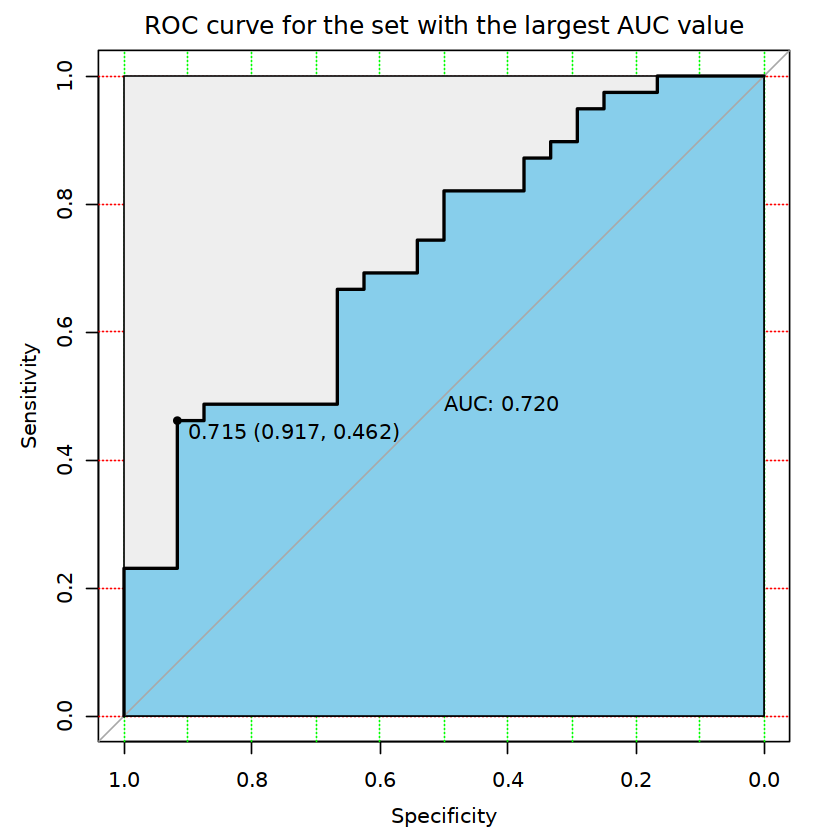

In [107]:
library(caret)
data = expr4
set.seed(1)
#单纯10折交叉验证，time=1
folds <-createMultiFolds(y=data$Group,k=5,times=10)
#10次批量训练与验证
#做成循环
auc_value<-as.numeric()
for(i in 1:10){
  train<- data[ folds[[i]],] 
  test <- data[-folds[[i]],] 
  model<-glm(Group~.,data=data,family=binomial())
    
  model_pre<-predict(model,type='response', newdata=train)
    
  auc_value<- append(auc_value,
                     as.numeric(pROC::auc(as.numeric(train[,1]),model_pre)))
}
mean(auc_value)
num <- which.max(auc_value)
print(auc_value)
fold_train <- data[folds[[num]],]   
fold_test <- data[-folds[[num]],]
fold_pre <- glm(Group~.,data=data,family=binomial())
fold_predict <- predict(fold_pre,type='response',newdata=data)
roc_curve <- pROC::roc(as.numeric(data$Group),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="ROC curve for the set with the largest AUC value")

In [108]:
library("autoReg")
overall.log =  glm(Group~.,data=data,family=binomial())
model3<-autoReg(overall.log,uni=TRUE,milti=TRUE,threshold=0.05)
model3

name,desc,0 (N=24),1 (N=39),id,OR (univariable),OR (multivariable)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
IGJ,Mean <U+00B1> SD,1056.8 <U+00B1> 853.6,1662.0 <U+00B1> 3344.1,IGJ,"1.00 (1.00-1.00, p=.450)",
BCL2A1,Mean <U+00B1> SD,516.6 <U+00B1> 511.5,992.6 <U+00B1> 1311.1,BCL2A1,"1.00 (1.00-1.00, p=.123)",
TXN,Mean <U+00B1> SD,4659.5 <U+00B1> 1902.0,6721.5 <U+00B1> 2771.3,TXN,"1.00 (1.00-1.00, p=.006)","1.00 (1.00-1.00, p=.006)"


In [116]:
library(ggplot2)

In [121]:
data$Group = as.factor(data$Group)

In [122]:
head(data,2)

,IGJ,BCL2A1,TXN,Group
,<dbl>,<dbl>,<dbl>,<fct>
GSM416528,309.6058,248.3601,3419.792,1
GSM416529,225.7952,227.4491,4389.589,1


In [123]:
library(pROC)

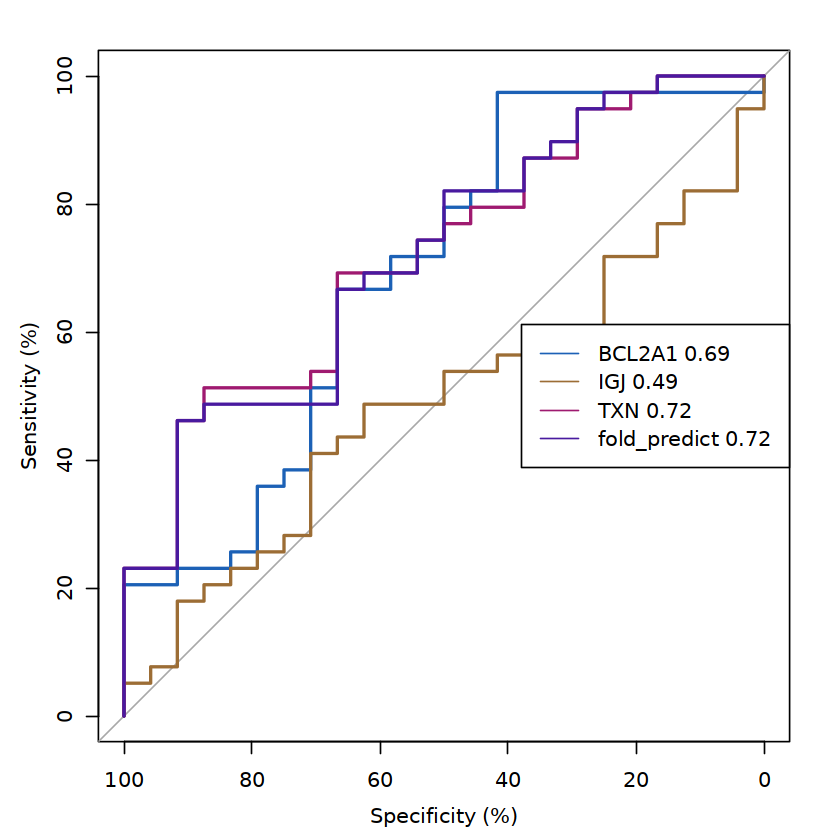

In [125]:
#pdf('ROC3.pdf',width = 6,height = 6)
rocobj1 <- plot.roc(data$Group, data$BCL2A1,percent=TRUE, levels=c(0,1),direction="<",col="#1c61b6")
#rocobj2 <- lines.roc(data$Group, data$FAM200B,percent=TRUE, levels=c(0,1),direction="<", col="#008600")
rocobj3 <- lines.roc(data$Group, data$IGJ,percent=TRUE, levels=c(0,1),direction="<", col="#9C6D35")
rocobj4 <- lines.roc(data$Group, data$TXN,percent=TRUE, levels=c(0,1),direction="<", col="#9F1A70")
rocobj5 <- lines.roc(data$Group, fold_predict,percent=TRUE, levels=c(0,1),direction="<", col="#491A9F")
legend("right", legend=c(paste0("BCL2A1 ", round(rocobj1$auc/100,digits = 2)),
                               #paste0("FAM200B ", round(rocobj2$auc/100,digits = 2)),
                               paste0("IGJ ", round(rocobj3$auc/100,digits = 2)),
                               paste0("TXN ", round(rocobj4$auc/100,digits = 2)),
                               paste0("fold_predict ", round(rocobj5$auc/100,digits = 2))),
       col=c("#1c61b6", "#9C6D35","#9F1A70","#491A9F"), lwd=1)
#dev.off()